In [1]:
%matplotlib inline

In [2]:
# import libraries 

import pandas as pd

# this is here to shut off some annoying warnings from pandas
pd.options.mode.chained_assignment = None

# matplotlib is one of the main plotting libraries we're going to use
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

# the other plotting library is seaborn - we'll use both during the class

# import seaborn as sns

# numpy and scipy are for handling numerical and scientific data

import numpy as np
import scipy as sp

#import statsmodels.formula.api as smf # basic statistical modeling

from scipy.stats.stats import pearsonr 

import os

import scipy
from scipy import stats
from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import entropy
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import nbinom
from scipy.stats.mstats import gmean

#from pandas.tools.plotting import scatter_matrix



### This lesson analyzes data from the following paper

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4878611/pdf/839.pdf

#### How many biological replicates are needed in an RNA-seq experiment and which differential expression tool should you use?

RNA-seq is now the technology of choice for genome-wide differential gene expression experiments, but it is not clear how many biological replicates are needed to ensure valid biological interpretation of the results or which statistical tools are best for analyzing the data. An RNA-seq experiment with 48 biological replicates in each of two conditions was performed to answer these questions and provide guidelines for experimental design. With three biological replicates, nine of the 11 tools evaluated found only 20%–40% of the significantly differentially expressed (SDE) genes identified with the full set of 42 clean replicates. This rises to >85% for the subset of SDE genes changing in expression by more than fourfold. To achieve >85% for all SDE genes regardless of fold change requires more than 20 biological replicates. The same nine tools successfully control their false discovery rate at ≲5% for all numbers of replicates, while the remaining two tools fail to control their FDR adequately, particularly for low numbers of replicates. For future RNA-seq experiments, these results suggest that at least six biological replicates should be used, rising to at least 12 when it is important to identify SDE genes for all fold changes. If fewer than 12 replicates are used, a superior combination of true positive and false positive performances makes edgeR and DESeq2 the leading tools. For higher replicate numbers, minimizing false positives is more important and DESeq marginally outperforms the other tools.

### Datafiles

There are 96 separate datafiles, each representing the processed output of an RNAseq experiment looking at mRNA levels in wild-type (48 samples) or SNF2 deletion (48 samples) yeast cells grown under standard condition. 

The files are incredible simple. Two columns, separated by tabs. The first column is the gene name, the second column the normalized counts for that gene in that sample (read the paper if you're interested in how they did the counting and normalization).

YBL013W 39
YBL014C 127
YBL015W 732
YBL016W 309
YBL017C 1613
YBL018C 174
YBL019W 117
YBL020W 258
YBL021C 248
YBL022C 1168
YBL023C 331
YBL024W 451
YBL025W 64
YBL026W 206
YBL027W 9723
YBL028C 77
YBL029C-A       157

Most of the genes have this naming format:

Systematic names for nuclear-encoded ORFs begin with the letter 'Y' (for 'Yeast'); the second letter denotes the chromosome number ('A' is chr I, 'B' is chr II, etc.); the third letter is either 'L' or 'R' for left or right chromosome arm; next is a three digit number indicating the order of the ORFs on that arm of a chromosome starting from the centromere, irrespective of strand; finally, there is an additional letter indicating the strand, either 'W' for Watson (the strand with 5' end at the left telomere) or 'C' for Crick (the complement strand, 5' end is at the right telomere).

You can read about the yeast gene naming system here - http://seq.yeastgenome.org/help/community/nomenclature-conventions. 

In [45]:
# load dataframe with expression data

datafile = "data/barton/Barton_combined.txt"
ye = pd.read_csv(datafile)   # the sep='\t' tells pandas that it is a tab separated file

ye = ye.set_index('Gene')

In [46]:
ye.head(20)

Snf2_rep01  Snf2_rep02  Snf2_rep03  Snf2_rep04  Snf2_rep05  \
Gene                                                                   
15S_rRNA           4           2           5           5          46   
21S_rRNA          31          18          23          44         356   
HRA1               5           1           3           1           2   
ICR1             205         196         211         252         127   
LSR1             210         103         159         260         298   
NME1              32          20          17          41          35   
PWR1               0           0           0           0           0   
Q0010              0           0           0           0           0   
Q0017              0           0           0           0           0   
Q0032              0           0           0           0           0   
Q0045              0           5           0           4           4   
Q0050              5           1           1           6          26   
Q0055              3           1           2           1          19   
Q0060              0           0           0           0           0   
Q0065              0           0           0           0           0   
Q0070              0           0           0           0           0   
Q0075              0           0           0           0           0   
Q0080              0           0           0           0           0   
Q0085              1           0           0           0           1   
Q0092              0           0           0           0           0   

          Snf2_rep06  Snf2_rep07  Snf2_rep08  Snf2_rep09  Snf2_rep10  ...  \
Gene                                                                  ...   
15S_rRNA           3           5           4           2          40  ...   
21S_rRNA          62          35          33          13         148  ...   
HRA1               1           1           4           4           0  ...   
ICR1             146         275         160         190         146  ...   
LSR1             522         303          96         132         263  ...   
NME1               7          37          20          16          45  ...   
PWR1               0           0           0           0           0  ...   
Q0010              0           0           0           0           0  ...   
Q0017              0           0           0           0           0  ...   
Q0032              0           0           0           0           0  ...   
Q0045              2           0           4           0           4  ...   
Q0050              9           2           3           1          20  ...   
Q0055              4           2           4           0          13  ...   
Q0060              0           0           0           0           1  ...   
Q0065              0           0           0           0           0  ...   
Q0070              0           0           0           0           0  ...   
Q0075              0           0           0           1           0  ...   
Q0080              0           0           0           0           0  ...   
Q0085              1           0           0           0           0  ...   
Q0092              0           0           0           0           0  ...   

          WT_rep39  WT_rep40  WT_rep41  WT_rep42  WT_rep43  WT_rep44  \
Gene                                                                   
15S_rRNA         0        49         9         4        11        12   
21S_rRNA        10       274        49        30        72        58   
HRA1             5         3         6         5         2         2   
ICR1            85       177       137       118       113        81   
LSR1            66       385       232       149       114        81   
NME1             6        52        31        22        10        15   
PWR1             0         0         0         0         0         0   
Q0010            0         0         0         0         0         0   
Q0017     

Before we go on it's a good idea to look at the data a bit.

Text(0, 0.5, 'Snf2_rep01')

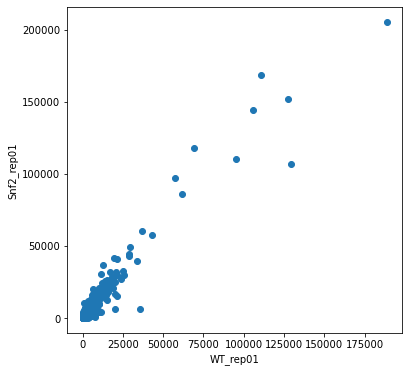

In [5]:
plt.figure(figsize=(6,6))
plt.scatter(ye['WT_rep01'],ye['Snf2_rep01'])
plt.xlabel('WT_rep01')
plt.ylabel('Snf2_rep01')

One immediately obvious problem is that the data are concentrated to the lower left, because there are only a few genes with really high expression levels. A typical way to get around this is to plot the axes on a log scale, which is trivial to do in matplotlib. 

(0.1, 1122018.4543019629)

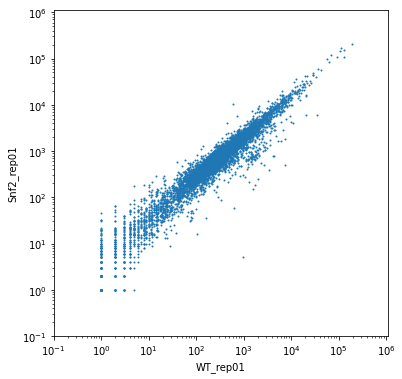

In [47]:
plt.figure(figsize=(6,6))

plt.scatter(ye['WT_rep01'],ye['Snf2_rep01'], s=1)

plt.xlabel('WT_rep01')
plt.xscale('log')
plt.xlim(.1,)

plt.ylabel('Snf2_rep01')
plt.yscale('log')
plt.ylim(.1,)

A few cosmetic things: I want to make the x and y axes the same since we expect the data to fall along the line y=x, to do this I figure out what the extreme values across both datasets are and limit the plot to them on both axes. 

In [48]:
ye['WT_rep01'].max()

188825

In [49]:
ye['Snf2_rep01'].max()

205731

(1, 226304.1)

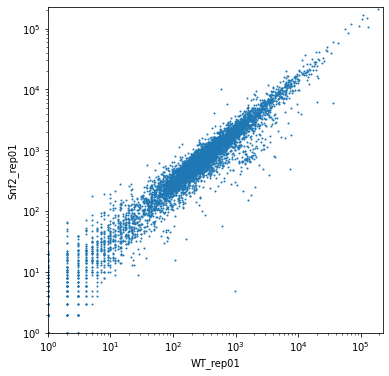

In [51]:
s1 = 'WT_rep01'
s2 = 'Snf2_rep01'

plt.figure(figsize=(6,6))
plt.scatter(ye[s1],ye[s2], s=1)

lower = 1
upper = 1.1 * max(ye[s1].max(),ye[s2].max())

plt.xlabel(s1)
plt.xscale('log')
plt.xlim(lower,upper)

plt.ylabel(s2)
plt.yscale('log')
plt.ylim(lower,upper)



Just eyeballing this it doesn't really look like the data fall along y=x. But lets add the line to tell for sure.

In [52]:
np.linspace(lower,upper,100)

array([1.00000000e+00, 2.28688990e+03, 4.57277980e+03, 6.85866970e+03,
       9.14455960e+03, 1.14304495e+04, 1.37163394e+04, 1.60022293e+04,
       1.82881192e+04, 2.05740091e+04, 2.28598990e+04, 2.51457889e+04,
       2.74316788e+04, 2.97175687e+04, 3.20034586e+04, 3.42893485e+04,
       3.65752384e+04, 3.88611283e+04, 4.11470182e+04, 4.34329081e+04,
       4.57187980e+04, 4.80046879e+04, 5.02905778e+04, 5.25764677e+04,
       5.48623576e+04, 5.71482475e+04, 5.94341374e+04, 6.17200273e+04,
       6.40059172e+04, 6.62918071e+04, 6.85776970e+04, 7.08635869e+04,
       7.31494768e+04, 7.54353667e+04, 7.77212566e+04, 8.00071465e+04,
       8.22930364e+04, 8.45789263e+04, 8.68648162e+04, 8.91507061e+04,
       9.14365960e+04, 9.37224859e+04, 9.60083758e+04, 9.82942657e+04,
       1.00580156e+05, 1.02866045e+05, 1.05151935e+05, 1.07437825e+05,
       1.09723715e+05, 1.12009605e+05, 1.14295495e+05, 1.16581385e+05,
       1.18867275e+05, 1.21153165e+05, 1.23439055e+05, 1.25724944e+05,
      

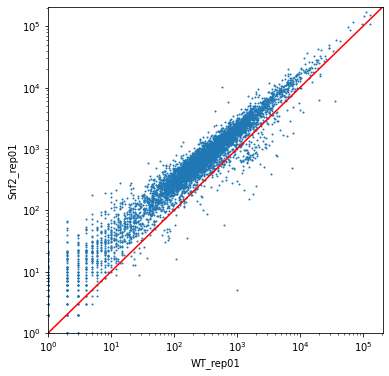

In [55]:
s1 = 'WT_rep01'
s2 = 'Snf2_rep01'

plt.figure(figsize=(6,6))
plt.scatter(ye[s1],ye[s2], s=1)

lower = 1
upper = max(ye[s1].max(),ye[s2].max())

plt.xlabel(s1)
plt.xscale('log')
plt.xlim(lower,upper)

plt.ylabel(s2)
plt.yscale('log')
plt.ylim(lower,upper)

x = np.linspace(lower,upper,100)
plt.plot(x,x,'r-')

They definitely don't. This is a bit of a problem for our analyses, since we're going to look for differentially expressed genes, and we start with the data skewed.  

There **SHOULD** have been taken care of in the software used to generate these files, but it evidently wasn't and is a good reason to check this kind of thing before you proceed with analyses.

A nice way to see this is to look at the ratio of the values. I generally convert this into log space as well, so that 2 fold up and 2 fold down look the same.

In [61]:
s1 = 'WT_rep01'
s2 = 'Snf2_rep01'

df = ye[(ye[s1] > 0) & (ye[s2] > 0)].copy()
df['rat'] = df[s1] / df[s2]
df['lrat'] = np.log(df['rat'])/np.log(2)

In [68]:
df['lrat'].median()

-1.2439255828860891

In [69]:
np.power(2,-1.2439255828860891)

0.4222222222222223

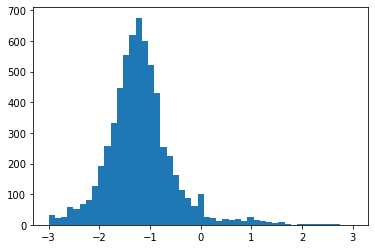

In [67]:
s1 = 'WT_rep01'
s2 = 'Snf2_rep01'

df = ye[(ye[s1] > 0) & (ye[s2] > 0)].copy()
df['rat'] = df[s1] / df[s2]
df['lrat'] = np.log(df['rat'])/np.log(2)

h = plt.hist(df['lrat'],bins=np.linspace(-3,3,50))

You can see the heavy skew here. We need to do someting about this.  

For most people the "proper" way to normalize such an experiment would be to make it so the "typical" gene remains the same between conditions. Note that this is a model, not an observation. But it's pretty easy to do. We take the distriution we see above and we adjust one of the values so that the middle of this distrution is set to 0 (a log of zero means a ratio of 1).

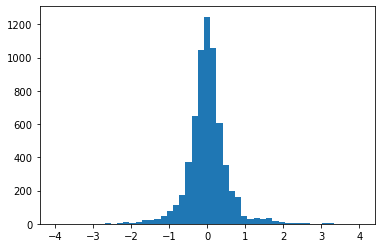

In [70]:
s1 = 'WT_rep01'
s2 = 'Snf2_rep01'

df = ye[(ye[s1] > 0) & (ye[s2] > 0)]

norm = np.median(df[s1]/df[s2])

h = plt.hist(np.log(df[s1]/(norm * df[s2])),bins=np.linspace(-4,4,50))

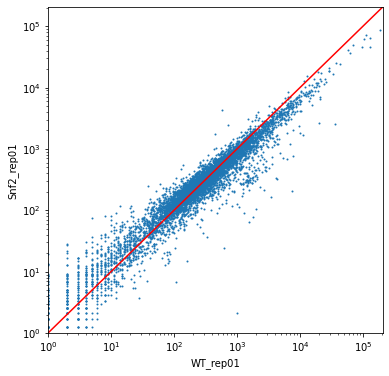

In [71]:
s1 = 'WT_rep01'
s2 = 'Snf2_rep01'

plt.figure(figsize=(6,6))
plt.scatter(ye[s1],ye[s2] * norm, s=1)

lower = 1
upper = max(df[s1].max(),df[s2].max())

plt.xlabel('WT_rep01')
plt.xscale('log')
plt.xlim(lower,upper)

plt.ylabel('Snf2_rep01')
plt.yscale('log')
plt.ylim(lower,upper)

plt.plot(np.linspace(lower,upper,100),np.linspace(lower,upper,100),'r-')

It's not perfect, but it will do for now (we'll return to this later).

So, which genes are differentially expressed? Let's start by doing the most common thing and just saying if it's 2x up or 2x down it's differentially expressed. It's easy to modify our plot to do this.

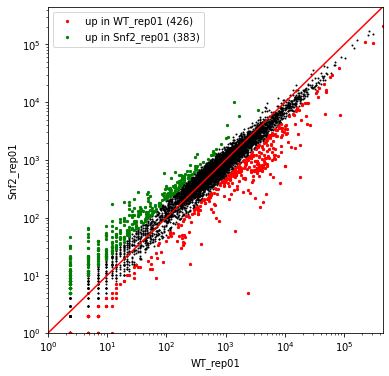

In [74]:
s1 = 'WT_rep01'
s2 = 'Snf2_rep01'

# Let's make a copy of our dataframe just so we don't mess up the original data

df = ye[[s1,s2]].copy()

# Now let's get rid of 0's so we don't mess up ratios

df = df[(df[s1] > 0) & (df[s2] > 0)]
norm = np.median(df[s1]/df[s2])

# apply norm

df[s1] = df[s1] / norm

# and apply the normalization

plt.figure(figsize=(6,6))
plt.scatter(df[s1],df[s2], s=1, c='black')

up = df[df[s1] > 2 * df[s2]]
plt.scatter(up[s1],up[s2], s=5, c='red', label = "up in " + s1 + " (%s)" % len(up))

up = df[df[s2] > 2 * df[s1]]
plt.scatter(up[s1],up[s2], s=5, c='green', label = "up in " + s2 + " (%s)" % len(up))
            
lower = 1
upper = max(df[s1].max(),df[s2].max())

plt.xlabel('WT_rep01')
plt.xscale('log')
plt.xlim(lower,upper)

plt.ylabel('Snf2_rep01')
plt.yscale('log')
plt.ylim(lower,upper)

plt.plot(np.linspace(lower,upper,100),np.linspace(lower,upper,100),'r-')

plt.legend()

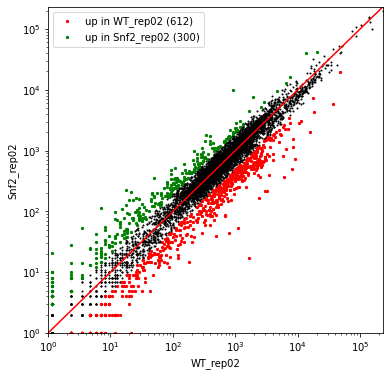

In [75]:
s1 = 'WT_rep02'
s2 = 'Snf2_rep02'

# Let's make a copy of our dataframe just so we don't mess up the original data

df = ye[[s1,s2]].copy()

# Now let's get rid of 0's so we don't mess up ratios

df = df[(df[s1] > 0) & (df[s2] > 0)]
norm = np.median(df[s1]/df[s2])

# apply norm

df[s1] = df[s1] / norm

# and apply the normalization

plt.figure(figsize=(6,6))
plt.scatter(df[s1],df[s2], s=1, c='black')

up = df[df[s1] > 2 * df[s2]]
plt.scatter(up[s1],up[s2], s=5, c='red', label = "up in " + s1 + " (%s)" % len(up))

up = df[df[s2] > 2 * df[s1]]
plt.scatter(up[s1],up[s2], s=5, c='green', label = "up in " + s2 + " (%s)" % len(up))
            
lower = 1
upper = max(df[s1].max(),df[s2].max())

plt.xlabel(s1)
plt.xscale('log')
plt.xlim(lower,upper)

plt.ylabel(s2)
plt.yscale('log')
plt.ylim(lower,upper)

plt.plot(np.linspace(lower,upper,100),np.linspace(lower,upper,100),'r-')

plt.legend()

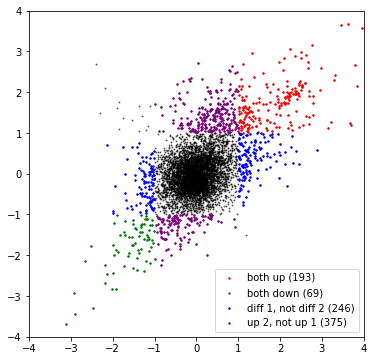

In [14]:
s1 = 'WT_rep01'
s2 = 'Snf2_rep01'
s3 = 'WT_rep02'
s4 = 'Snf2_rep02'

df = ye[[s1,s2,s3,s4]].copy()

# get rid of poorly expressed genes

df = df[df.min(axis=1) > 10]

norm1 = np.median(df[s1]/df[s2])
df[s1] = df[s1] / norm1

norm2 =  np.median(df[s3]/df[s4])
df[s3] = df[s3] / norm2

df['lrat1'] = np.log(df[s1]/df[s2]) / np.log(2)
df['lrat2'] = np.log(df[s3]/df[s4]) / np.log(2)

plt.figure(figsize=(6,6))
plt.scatter(df['lrat1'],df['lrat2'],s=1,color='black',alpha=.5)

dfp = df[(df['lrat1'] >= 1) & (df['lrat2'] >=1)]
plt.scatter(dfp['lrat1'],dfp['lrat2'],s=2,color='red', label="both up (%s)" % len(dfp))

dfp = df[(df['lrat1'] <= -1) & (df['lrat2'] <= -1)]
plt.scatter(dfp['lrat1'],dfp['lrat2'],s=2,color='green', label="both down (%s)" % len(dfp))

dfp = df[(np.abs(df['lrat1']) >= 1) & (np.abs(df['lrat2']) < 1)]
plt.scatter(dfp['lrat1'],dfp['lrat2'],s=2,color='blue', label="diff 1, not diff 2 (%s)" % len(dfp))

dfp = df[(np.abs(df['lrat2']) >= 1) & (np.abs(df['lrat1']) < 1)]
plt.scatter(dfp['lrat1'],dfp['lrat2'],s=2,color='purple', label="up 2, not up 1 (%s)" % len(dfp))


plt.xlim(-4,4)
plt.ylim(-4,4)
plt.legend()

We obviously need to be a bit more sophisticated in how we approach this analysis.  

First, let's deal with normalization of the dataset as a whole.  

We could stick to pairs of matched samples and just do this comparison for WT_1 and Snf2_1, then WT_2 and Snf2_2, etc... But since we're going to be doing analyses that are not just pairwise, let's think about this globally. Instead of normalizing pairs of samples against each other, we're going to make a common reference and normalize to that. We could just choose one experiment, but that's likely to bias our data.  

What could we use instead?

Some people create a synthetic reference sample that is the mean across all samples. Others use median. Here we use the geometric mean, which is the mean in log space. It probably doesn't make a significant difference, but since we end up doing a lot of comparisons in ratio space this makes the most sense (to me at least).

We need to do a bit of bookkeeping, and make lists of experiments that we can feed to pandas to calculate means, etc.

In [76]:
# this comment gets all of the column names and puts them into a list

exps = {}

exps['wt'] = [e for e in ye.columns if e.startswith('WT')] 

exps['mut'] = [e for e in ye.columns if e.startswith('Snf2')] 

exps['all'] = exps['wt'] + exps['mut']

So now lets compute some new columns, including mean, median and geometric mean for the whole dataset, as well as for wt and mut. Note that we're doing this separately for each gene.

In [79]:
ye['all_mean']   = ye[exps['all']].mean(axis=1)
ye['all_median'] = ye[exps['all']].median(axis=1)
ye['all_gmean']  = gmean(ye[exps['all']].values,axis=1)

ye['wt_mean']   = ye[exps['wt']].mean(axis=1)
ye['wt_median'] = ye[exps['wt']].median(axis=1)
ye['wt_gmean']  = gmean(ye[exps['wt']].values,axis=1)

ye['mut_mean']   = ye[exps['mut']].mean(axis=1)
ye['mut_median'] = ye[exps['mut']].median(axis=1)
ye['mut_gmean']  = gmean(ye[exps['mut']].values,axis=1)

In [80]:
# we could do this in a more compact way

for d in ['all','wt','mut']:
    ye[d + '_mean']   = ye[exps[d]].mean(axis=1)
    ye[d + '_median'] = ye[exps[d]].median(axis=1)
    ye[d + '_gmean']  = gmean(ye[exps[d]].values,axis=1)

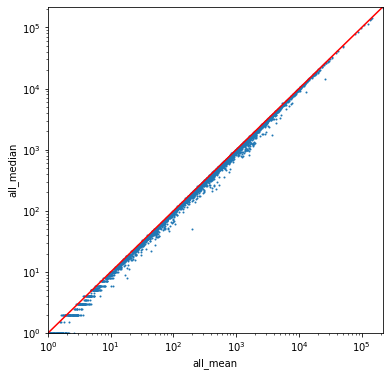

In [81]:
s1 = 'all_mean'
s2 = 'all_median'

plt.figure(figsize=(6,6))
plt.scatter(ye[s1],ye[s2], s=1)

lower = 1
upper = max(ye[s1].max(),ye[s2].max())

plt.xlabel(s1)
plt.xscale('log')
plt.xlim(lower,upper)

plt.ylabel(s2)
plt.yscale('log')
plt.ylim(lower,upper)

plt.plot(np.linspace(lower,upper,100),np.linspace(lower,upper,100),'r-')

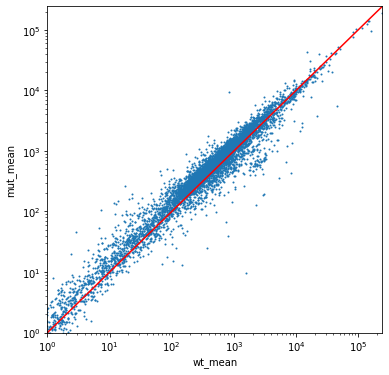

In [82]:
s1 = 'wt_mean'
s2 = 'mut_mean'

plt.figure(figsize=(6,6))
plt.scatter(ye[s1],ye[s2], s=1)

lower = 1
upper = max(ye[s1].max(),ye[s2].max())

plt.xlabel(s1)
plt.xscale('log')
plt.xlim(lower,upper)

plt.ylabel(s2)
plt.yscale('log')
plt.ylim(lower,upper)

plt.plot(np.linspace(lower,upper,100),np.linspace(lower,upper,100),'r-')

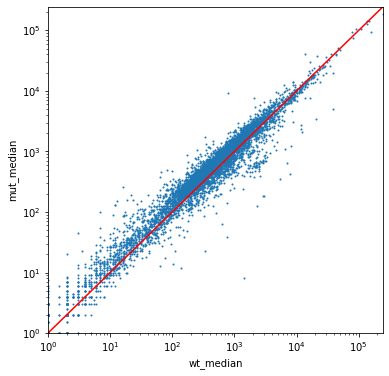

In [20]:
s1 = 'wt_median'
s2 = 'mut_median'

plt.figure(figsize=(6,6))
plt.scatter(ye[s1],ye[s2], s=1)

lower = 1
upper = max(ye[s1].max(),ye[s2].max())

plt.xlabel(s1)
plt.xscale('log')
plt.xlim(lower,upper)

plt.ylabel(s2)
plt.yscale('log')
plt.ylim(lower,upper)

plt.plot(np.linspace(lower,upper,100),np.linspace(lower,upper,100),'r-')

It's getting kind of annoying to copy and paste the plot code, so let's write a function to do it for us.

In [21]:
def scatter_exps(ye,s1,s2):
    plt.figure(figsize=(6,6))
    plt.scatter(ye[s1],ye[s2], s=1)

    lower = 1
    upper = max(ye[s1].max(),ye[s2].max())

    plt.xlabel(s1)
    plt.xscale('log')
    plt.xlim(lower,upper)

    plt.ylabel(s2)
    plt.yscale('log')
    plt.ylim(lower,upper)

    plt.plot(np.linspace(lower,upper,100),np.linspace(lower,upper,100),'r-')


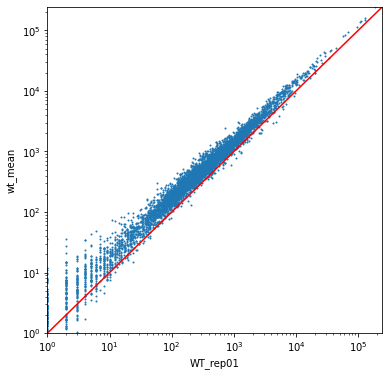

In [22]:
scatter_exps(ye,"WT_rep01","wt_mean")

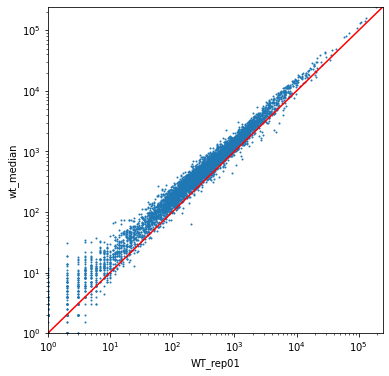

In [23]:
scatter_exps(ye,"WT_rep01","wt_median")

Now, let's normalize each of the datasets. What we're going to do is simple. For each experiment we're going to calculate a normalization factor by looking at the distribution across all genes, of the ratio of the expression value of that gene against the geometric mean.

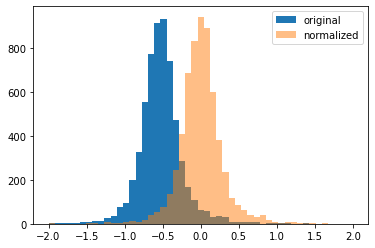

In [24]:
c = 'WT_rep01'

# since we're going to do ratios, let's ignore genes where the gmean is very small

df = ye[ye['all_gmean'] > 10]

h1 = plt.hist(np.log(df[c]/df['all_gmean']),bins=np.linspace(-2,2,50), label="original")

norm = np.median(df[c]/df['all_gmean'])

h2 = plt.hist(np.log((1/norm) * df[c]/df['all_gmean']),bins=np.linspace(-2,2,50), label="normalized",alpha=.5)

plt.legend()

In [83]:
def scatter_exps(ye,s1,s2,norm=1):
    plt.figure(figsize=(6,6))
    plt.scatter(ye[s1]/norm,ye[s2], s=1)

    lower = 1
    upper = max(ye[s1].max(),ye[s2].max())

    plt.xlabel(s1)
    plt.xscale('log')
    plt.xlim(lower,upper)

    plt.ylabel(s2)
    plt.yscale('log')
    plt.ylim(lower,upper)

    plt.plot(np.linspace(lower,upper,100),np.linspace(lower,upper,100),'r-')

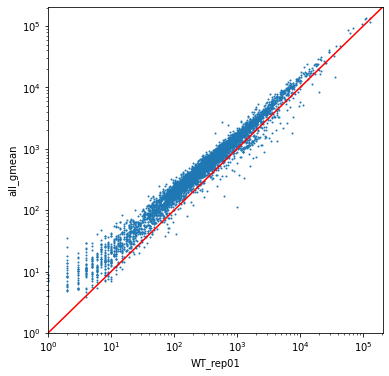

In [84]:
scatter_exps(ye,'WT_rep01','all_gmean')

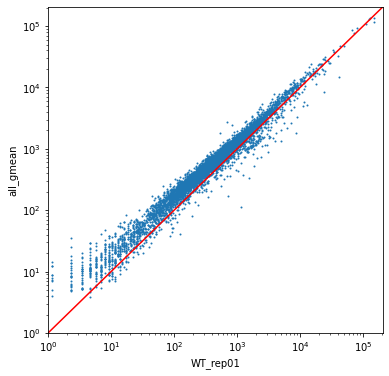

In [86]:
scatter_exps(ye,'WT_rep01','all_gmean',norm=norm)

In [87]:
# finally, apply to all columns

df = ye[ye['all_gmean'] > 10]

for c in exps['all']:
    norm = np.median(df[c]/df['all_gmean'])
    ye[c] = ye[c] / norm

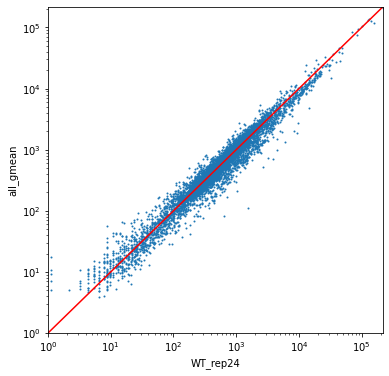

In [29]:
scatter_exps(ye,'WT_rep24','all_gmean')

In [89]:
# we could do this in a more compact way

for d in ['all','wt','mut']:
    ye[d + '_mean']   = ye[exps[d]].mean(axis=1)
    ye[d + '_median'] = ye[exps[d]].median(axis=1)
    ye[d + '_gmean']  = gmean(ye[exps[d]].values,axis=1)

/Users/eisen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


So, with this whole dataset, we're getting as close as we can to measuring the true differential expression between the two conditions.

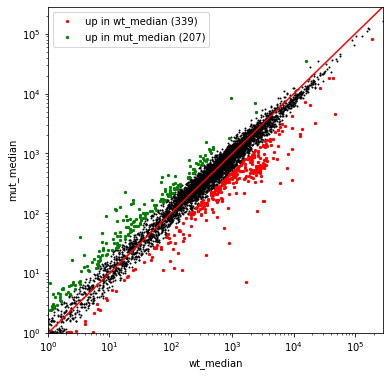

In [90]:
s1 = 'wt_median'
s2 = 'mut_median'

# Let's make a copy of our dataframe just so we don't mess up the original data

df = ye[[s1,s2]].copy()

# Now let's get rid of 0's so we don't mess up ratios

df = df[(df[s1] > 0) & (df[s2] > 0)]
norm = np.median(df[s1]/df[s2])

# apply norm

df[s1] = df[s1] / norm

# and apply the normalization

plt.figure(figsize=(6,6))
plt.scatter(df[s1],df[s2], s=1, c='black')

up = df[df[s1] > 2 * df[s2]]
plt.scatter(up[s1],up[s2], s=5, c='red', label = "up in " + s1 + " (%s)" % len(up))

up = df[df[s2] > 2 * df[s1]]
plt.scatter(up[s1],up[s2], s=5, c='green', label = "up in " + s2 + " (%s)" % len(up))
            
lower = 1
upper = max(df[s1].max(),df[s2].max())

plt.xlabel(s1)
plt.xscale('log')
plt.xlim(lower,upper)

plt.ylabel(s2)
plt.yscale('log')
plt.ylim(lower,upper)

plt.plot(np.linspace(lower,upper,100),np.linspace(lower,upper,100),'r-')

plt.legend()

In [91]:
ye['true_de'] = np.log(ye['wt_median'] / ye['mut_median'])/np.log(2)
ye['abs_true_de'] = np.abs(ye['true_de'])


/Users/eisen/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


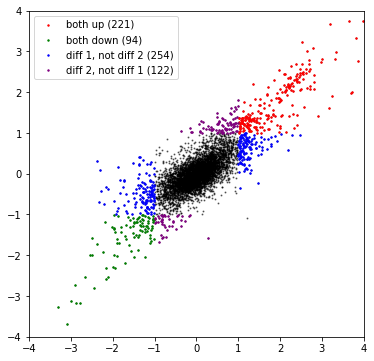

In [92]:
s1 = 'WT_rep01'
s2 = 'Snf2_rep01'
s3 = 'wt_median'
s4 = 'mut_median'

df = ye[[s1,s2,s3,s4]].copy()

# get rid of poorly expressed genes

df = df[df.min(axis=1) > 10]

df['lrat1'] = np.log(df[s1]/df[s2]) / np.log(2)
df['lrat2'] = np.log(df[s3]/df[s4]) / np.log(2)

plt.figure(figsize=(6,6))
plt.scatter(df['lrat1'],df['lrat2'],s=1,color='black',alpha=.5)

dfp = df[(df['lrat1'] >= 1) & (df['lrat2'] >=1)]
plt.scatter(dfp['lrat1'],dfp['lrat2'],s=2,color='red', label="both up (%s)" % len(dfp))

dfp = df[(df['lrat1'] <= -1) & (df['lrat2'] <= -1)]
plt.scatter(dfp['lrat1'],dfp['lrat2'],s=2,color='green', label="both down (%s)" % len(dfp))

dfp = df[(np.abs(df['lrat1']) >= 1) & (np.abs(df['lrat2']) < 1)]
plt.scatter(dfp['lrat1'],dfp['lrat2'],s=2,color='blue', label="diff 1, not diff 2 (%s)" % len(dfp))

dfp = df[(np.abs(df['lrat2']) >= 1) & (np.abs(df['lrat1']) < 1)]
plt.scatter(dfp['lrat1'],dfp['lrat2'],s=2,color='purple', label="diff 2, not diff 1 (%s)" % len(dfp))


plt.xlim(-4,4)
plt.ylim(-4,4)
plt.legend()

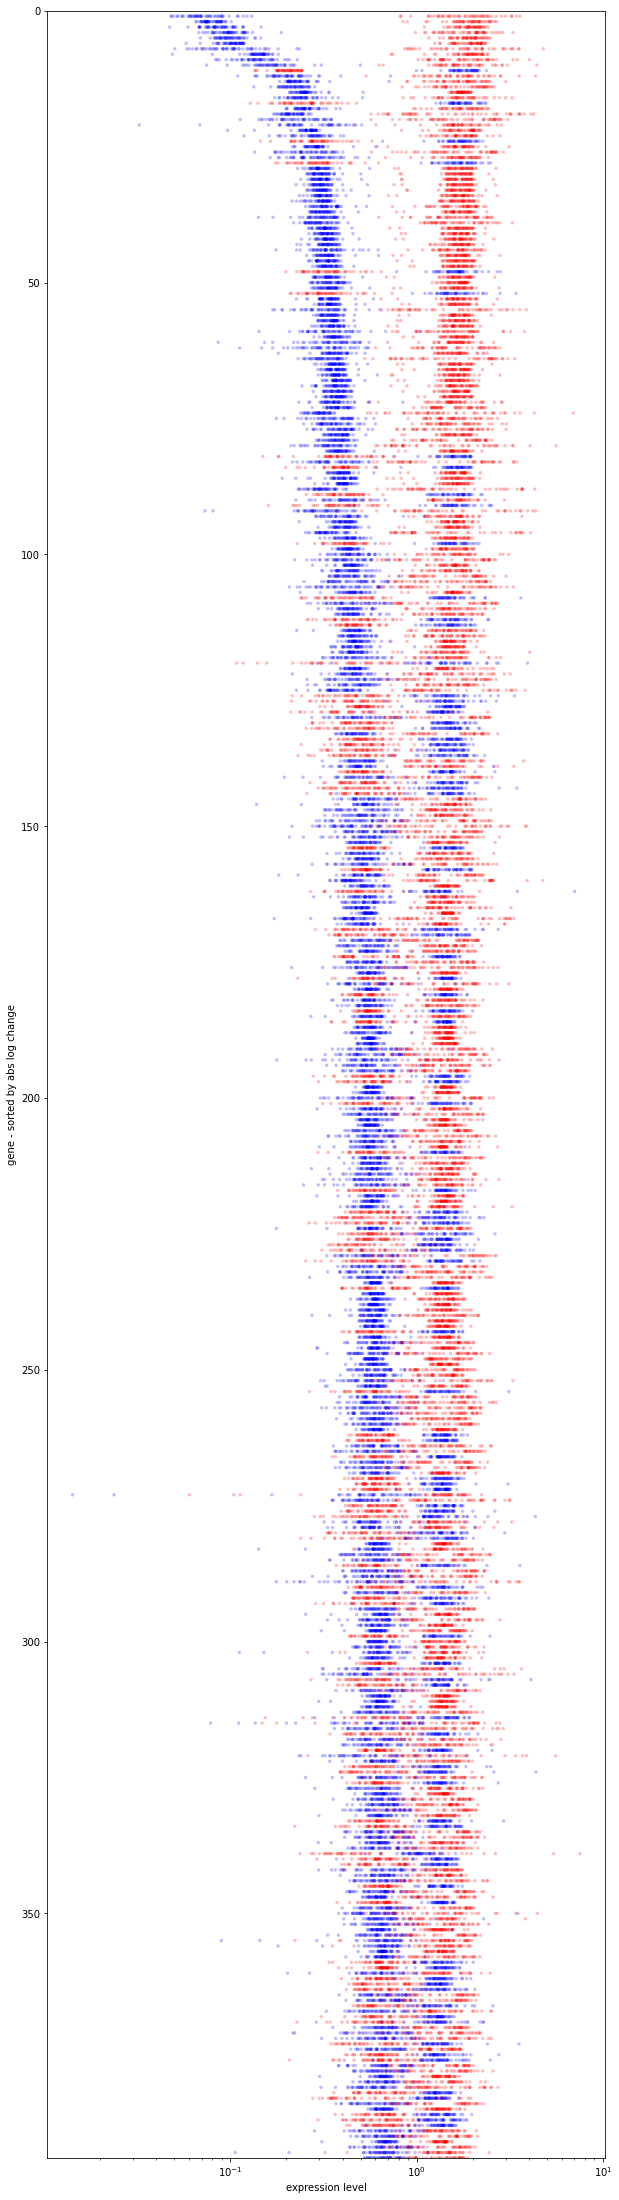

In [95]:
df = ye.copy()
df = df[df[exps['all']].min(axis=1) > 10]
df = df[df['abs_true_de'] > 1]
df['abs_true_de'] = np.abs(df['true_de'])
df = df.sort_values('abs_true_de',ascending=False)

for c in exps['all']:
    df[c] = df[c] / df['all_mean']
    
mut_ind = []
mut = []
wt_ind = [] 
wt = []

row = 0
for i,r in df.iterrows():
    for c in exps['mut']:
        mut_ind.append(row+1)
        mut.append(r[c])
    for c in exps['wt']:
        wt_ind.append(row+1)
        wt.append(r[c])
    row = row + 1
        
fig = plt.figure(figsize = (10,.1*max(wt_ind)))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(max(wt_ind + mut_ind),0)
ax.set_xscale("log", nonpositive='clip')
ax.set_xlabel("expression level")
ax.set_ylabel("gene - sorted by abs log change")
ax.scatter(wt,wt_ind,s=12,alpha=.25,c='r',edgecolor='none')
ax.scatter(mut,mut_ind,s=12,alpha=.25,c='b',edgecolor='none')

In [96]:
df.head(10)

Snf2_rep01  Snf2_rep02  Snf2_rep03  Snf2_rep04  Snf2_rep05  \
Gene                                                                  
YHR136C    0.089494    0.089123    0.051848    0.063967    0.078703   
YML123C    0.074622    0.094817    0.073738    0.070786    0.073473   
YHR215W    0.083334    0.116111    0.082193    0.075586    0.076028   
YER011W    0.079590    0.119734    0.115582    0.096536    0.102309   
YAR071W    0.108015    0.118286    0.084756    0.098353    0.101800   
YGR234W    0.091759    0.111168    0.102556    0.085081    0.086189   
YDL037C    0.122964    0.180378    0.090811    0.074517    0.106400   
YDR033W    0.140366    0.162219    0.153043    0.123894    0.153203   
YGR035C    0.145973    0.115469    0.100909    0.114551    0.132571   
YDR077W    0.156191    0.194946    0.157997    0.147411    0.168626   

         Snf2_rep06  Snf2_rep07  Snf2_rep08  Snf2_rep09  Snf2_rep10  ...  \
Gene                                                                 ...   
YHR136C    0.048450    0.065148    0.091256    0.069476    0.054993  ...   
YML123C    0.082428    0.074488    0.092264    0.086073    0.065498  ...   
YHR215W    0.047202    0.076567    0.117044    0.068036    0.067998  ...   
YER011W    0.187673    0.119519    0.097525    0.080358    0.116514  ...   
YAR071W    0.069032    0.093272    0.135406    0.082377    0.095325  ...   
YGR234W    0.057852    0.094461    0.116829    0.105398    0.117130  ...   
YDL037C    0.227749    0.082726    0.136831    0.104174    0.095162  ...   
YDR033W    0.048767    0.135961    0.168772    0.149097    0.130965  ...   
YGR035C    0.118629    0.135062    0.137112    0.115572    0.087112  ...   
YDR077W    0.498992    0.195025    0.186144    0.134401    0.074570  ...   

           all_median     all_gmean       wt_mean     wt_median      wt_gmean  \
Gene                                                                            
YHR136C    219.803350    168.461724    895.461852    867.815256    842.353045   
YML123C   2259.666312   1840.570117   9177.777318   9400.580762   8925.851514   
YHR215W    816.414247    528.528905   2502.965851   2515.643006   2474.942293   
YER011W    983.121791    710.486701   3186.828424   3235.796330   3066.585256   
YAR071W   1094.149163    721.618614   3180.794983   3186.980698   3139.107802   
YGR234W   2097.043402   1331.948330   5820.113741   6011.044069   5747.473999   
YDL037C     41.683510     81.684801    386.849584    370.541559    326.141381   
YDR033W   1844.976043   2030.076750   7538.855672   7756.124944   7345.824892   
YGR035C    263.266709    207.162055    786.613945    737.890395    745.405045   
YDR077W  15478.394195  14720.899958  50144.468685  45764.491882  47341.870522   

            mut_mean   mut_median    mut_gmean   true_de  abs_true_de  
Gene                                                                   
YHR136C    34.731929    32.266522    33.690568  4.749278     4.749278  
YML123C   381.576095   367.427826   379.537835  4.677217     4.677217  
YHR215W   114.980420   111.117460   112.868411  4.500770     4.500770  
YER011W   167.398415   163.775286   164.610246  4.304331     4.304331  
YAR071W   167.747188   163.124214   165.885805  4.288147     4.288147  
YGR234W   311.492696   315.735686   308.672359  4.250826     4.250826  
YDL037C    21.685101    20.155737    20.458633  4.200373     4.200373  
YDR033W   569.812335   581.510007   561.027750  3.737460     3.737460  
YGR035C    58.982744    57.525468    57.574224  3.681134     3.681134  
YDR077W  4789.211362  4535.472083  4577.446839  3.334904     3.334904  

[10 rows x 107 columns]

In [34]:
ye['ttest-p'] = scipy.stats.ttest_ind(ye[exps['wt']],ye[exps['mut']], axis=1, equal_var=False).pvalue

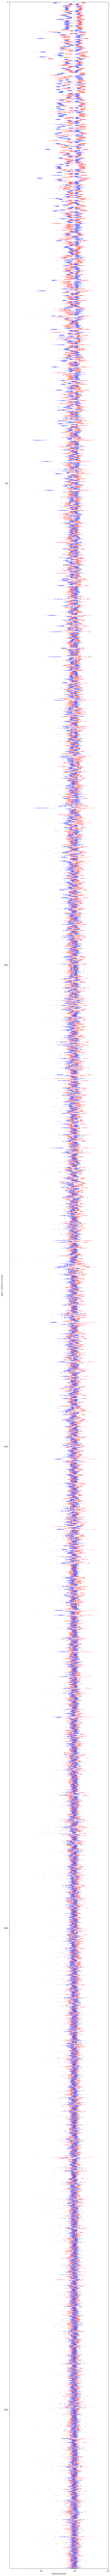

In [35]:
df = ye.copy()
df = df[df[exps['all']].min(axis=1) > 10]
df = df[df['ttest-p'] < .01 / 6000]
df = df.sort_values('ttest-p',ascending=True)

for c in exps['all']:
    df[c] = df[c] / df['all_mean']
    
mut_ind = []
mut = []
wt_ind = [] 
wt = []

row = 0
for i,r in df.iterrows():
    for c in exps['mut']:
        mut_ind.append(row+1)
        mut.append(r[c])
    for c in exps['wt']:
        wt_ind.append(row+1)
        wt.append(r[c])
    row = row + 1
        
fig = plt.figure(figsize = (10,.1*max(wt_ind)))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(max(wt_ind + mut_ind),0)
ax.set_xscale("log", nonpositive='clip')
ax.set_xlabel("expression level")
ax.set_ylabel("gene - sorted by mut/wt")
ax.scatter(wt,wt_ind,s=12,alpha=.25,c='r',edgecolor='none')
ax.scatter(mut,mut_ind,s=12,alpha=.25,c='b',edgecolor='none')

In [36]:
def rowks(sample1,sample2):
    return scipy.stats.ks_2samp(sample1,sample2).pvalue    

ye['ks-p'] = ye.apply(lambda row: rowks(row[exps['wt']],row[exps['mut']]), axis=1)

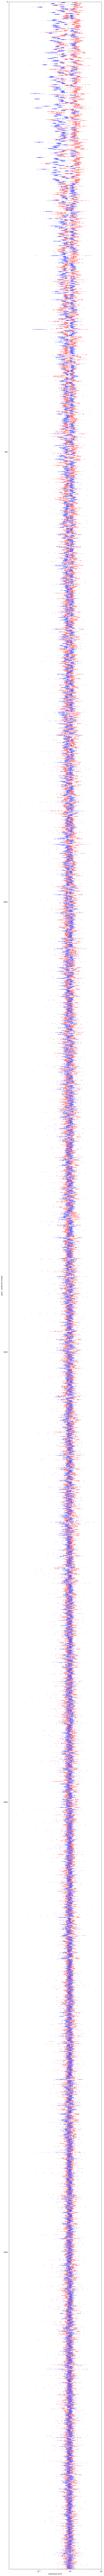

In [37]:
df = ye.copy()
df = df[df[exps['all']].min(axis=1) > 10]
df = df[df['ks-p'] < .01 / 6000]
df = df.sort_values('ks-p',ascending=True)

for c in exps['all']:
    df[c] = df[c] / df['all_mean']
    #df[c] = (df[c]) / df['all_mean']

    
mut_ind = []
mut = []
wt_ind = [] 
wt = []

row = 0
for i,r in df.iterrows():
    for c in exps['mut']:
        mut_ind.append(row+1)
        mut.append(r[c])
    for c in exps['wt']:
        wt_ind.append(row+1)
        wt.append(r[c])
    row = row + 1
        
fig = plt.figure(figsize = (10,.1*max(wt_ind)))
ax = fig.add_subplot(1,1,1)
#ax.set_xlim(-2,2)
ax.set_ylim(max(wt_ind + mut_ind),0)
ax.set_xscale("log", nonpositive='clip')
ax.set_xlabel("expression level")
ax.set_ylabel("gene - sorted by mut/wt")
ax.scatter(wt,wt_ind,s=12,alpha=.25,c='r',edgecolor='none')
ax.scatter(mut,mut_ind,s=12,alpha=.25,c='b',edgecolor='none')

What happens if we have fewer samples?

In [38]:
results = []

for sample_size in np.arange(5,48):
    for reps in np.arange(0,25):
        
        sam = {}
        
        sam['wt']  = list(np.random.choice(exps['wt'],sample_size))
        sam['mut'] = list(np.random.choice(exps['mut'],sample_size))
        sam['all'] = sam['wt'] + sam['mut']

        df = ye[sam['all']]
        tt = scipy.stats.ttest_ind(ye[sam['wt']],ye[sam['mut']], axis=1, equal_var=False).pvalue
        #ks = df.apply(lambda row: rowks(row[sam['wt']],row[sam['mut']]), axis=1)
        results.append([sample_size,len(tt[tt < .01 / 6000])])
        
tt = pd.DataFrame(data=results,columns=['sample_size','N'])

In [39]:
tt = pd.DataFrame(data=results,columns=['sample_size','N'])

Text(0, 0.5, 'Number of Genes\nCalled Differentially Expressed')

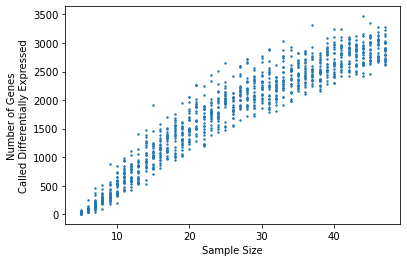

In [40]:
plt.scatter(tt.sample_size,tt.N, s= 2)
plt.xlabel('Sample Size')
plt.ylabel('Number of Genes\nCalled Differentially Expressed')

In [ ]:
mat1 = ye[sam['wt']].values
mat2 = ye[sam['mut']].values

ksp = [ks_2samp(mat1[i],mat2[i]).pvalue for i in range(0,len(mat1))]

In [71]:
ksp

[0.07088798787114439,
 0.015643390496754332,
 0.0025300622362698397,
 4.326943555111202e-08,
 0.006548396368058784,
 0.23907300248018645,
 1.0,
 1.0,
 1.0,
 1.0]

In [42]:
results = []

for sample_size in np.arange(5,48):
    for reps in np.arange(0,10):
        
        sam = {}
        
        sam['wt']  = list(np.random.choice(exps['wt'],sample_size))
        sam['mut'] = list(np.random.choice(exps['mut'],sample_size))
        sam['all'] = sam['wt'] + sam['mut']
    
        mat1 = ye[sam['wt']].values
        mat2 = ye[sam['mut']].values

        ks = np.array([ks_2samp(mat1[i],mat2[i]).pvalue for i in range(0,len(mat1))])
        results.append([sample_size,len(ks[ks < .01 / 6000])])
        
ks = pd.DataFrame(data=results,columns=['sample_size','N'])

Text(0, 0.5, 'Number of Genes\nCalled Differentially Expressed')

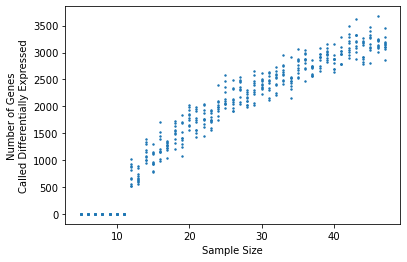

In [43]:
plt.scatter(ks.sample_size,ks.N, s= 2)
plt.xlabel('Sample Size')
plt.ylabel('Number of Genes\nCalled Differentially Expressed')